# Did not work - plots all look the same and I didn't have the brain power to figure out why

Author: @emilyekstrum
<br> 11/17/25

In [1]:

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix

import sys
sys.path.append(r"C:\Users\denmanlab\Desktop\Emily_rotation\Emily_rotation\PyCliqueTop_2023")
from compute_betti_curves import compute_betti_curves
from plot_betti_curves import plot_betti_curves


Embedding loaded for C159
Sparse distance matrix size: (500, 500)
Betti curves computed


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\denmanlab\\Desktop\\Emily_rotation\\8d_embed_good_vis\\Betti Cuves\\CEBRA_LGN_8d_drift_grat_C159.png'

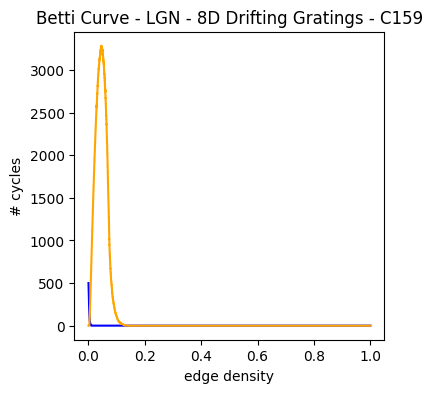

In [ ]:
import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import os

sys.path.append("/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/PyCliqueTop_2023")
from compute_betti_curves import compute_betti_curves
from plot_betti_curves import plot_betti_curves
from matrix_2_persistence_diagrams import matrix_2_persistence_diagrams


def load_embedding_data(filepath):
    with open(filepath, "rb") as f:
        ss = pkl.load(f)
        names = list(ss.keys())
    return ss, names

def fps_downsample(X, n_target, seed=0):
    """Farthest point sampling downsampling
    
    Args:
        X: np.ndarray input embedding, shape (N, D)
        n_target: int, target number of points after downsampling
    Returns:
        X_ds: np.ndarray, shape (n_target, D) -> downsampled embedding"""

    X = np.asarray(X, dtype=np.float32)
    N = X.shape[0]
    if n_target is None or n_target >= N:
        return X
    rng = np.random.default_rng(seed)
    idx = [int(rng.integers(0, N))]
    dmin = np.linalg.norm(X - X[idx[0]], axis=1)
    for _ in range(1, int(n_target)):
        nxt = int(np.argmax(dmin))
        idx.append(nxt)
        dmin = np.minimum(dmin, np.linalg.norm(X - X[nxt], axis=1))
    return X[np.array(idx, dtype=int)]

def knn_sparse_dist(embedding, n_neighbors=100, metric="euclidean"):
    """Makes symmetric sparse distance matrix
    
    Args:
        embedding: np.ndarray, shape (N, D)
        n_neighbors: int, number of nearest neighbors to use
        metric: str, distance metric to use
    Returns:
        sparse_matrix: csr_matrix, shape (N, N)"""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))
    # Symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())
    return sparse_matrix



def clique_top(embedding_path, session, max_dim,title_string):
    """ Compute and plot Betti curves from CEBRA embedding

    Args:
        embedding_path: str, path to pickle file containing embeddings
        session: str, session name to load from pickle file
        max_dim: int, maximum homology dimension to compute Betti curves for
        title_string: str, title for Betti curve plot
    """

    colors = ['blue', 'orange', 'green']

    embeddings, names = load_embedding_data(embedding_path)
    embedding = np.asarray(embeddings[session]["embedding"], dtype=np.float32)
    print(f"Embedding loaded for {session}")

    ds_embed = fps_downsample(embedding, n_target=500, seed=0)

    d_matrix  = knn_sparse_dist(ds_embed, n_neighbors=100, metric='euclidean')
    print(f"Sparse distance matrix size: {d_matrix.shape}")

    BCs, edge_densities = compute_betti_curves(d_matrix, max_dim=max_dim, similarity=False)
    print("Betti curves computed")

    fig, ax = plt.subplots(figsize=(4, 4))

    plot_betti_curves(ax=ax, BCs=BCs, edge_densities=edge_densities, colors=colors, title_string=title_string)
    plt.savefig(os.path.join(r'C:\Users\denmanlab\Desktop\Emily_rotation\8d_embed_good_vis\Betti Cuves','CEBRA_LGN_8d_drift_grat_C159'))
    plt.show()

if __name__ == "__main__":
    embedding_path = (r"C:\Users\denmanlab\Desktop\Emily_rotation\8d_embed\LGN_8d_CEBRA_unsup_time_drifting_gratings.pkl")
    session = "C159"  
    max_dim = 1
    title = "Betti Curve - LGN - 8D Drifting Gratings - C159"

    clique_top(embedding_path, session, max_dim, title)
